In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Machine Learning

## Scaling

In [2]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

## Learning rate + regularization

Epoch 1/100
591/591 [==============================] - 6s 9ms/step - loss: 1.4258 - val_loss: 0.5740 - lr: 0.0010
Epoch 2/100
591/591 [==============================] - 5s 9ms/step - loss: 0.4004 - val_loss: 0.3509 - lr: 0.0010
Epoch 3/100
591/591 [==============================] - 5s 9ms/step - loss: 0.3093 - val_loss: 0.3395 - lr: 0.0010
Epoch 4/100
591/591 [==============================] - 5s 9ms/step - loss: 0.2883 - val_loss: 0.2575 - lr: 0.0010
Epoch 5/100
591/591 [==============================] - 5s 9ms/step - loss: 0.2887 - val_loss: 0.2631 - lr: 0.0010
Epoch 6/100
591/591 [==============================] - 5s 9ms/step - loss: 0.2920 - val_loss: 0.2472 - lr: 0.0010
Epoch 7/100
591/591 [==============================] - 5s 9ms/step - loss: 0.2888 - val_loss: 0.4197 - lr: 0.0010
Epoch 8/100
591/591 [==============================] - 7s 11ms/step - loss: 0.2953 - val_loss: 0.2658 - lr: 0.0010
Epoch 9/100
591/591 [==============================] - 5s 9ms/step - loss: 0.2918 - val

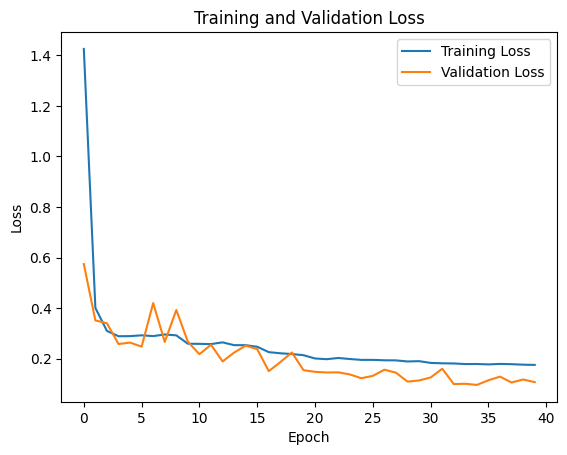

In [13]:
# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\dataset\simulation_results_new.csv")

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3


# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Apply custom scaling
X_scaled = custom_scaling(X)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 1 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),     
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),       
    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    # tf.keras.layers.BatchNormalization(),                  # Batch normalization
    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    # tf.keras.layers.BatchNormalization(),       
    tf.keras.layers.Dense(6, activation='softplus')         # Output layer with 6 neurons
])


# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Train the model with custom callback to print information at the end of each epoch and early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=1)


# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Optionally, save the model
model.save("model_5_512_new.h5")

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

127/127 [==============================] - 0s 3ms/step - loss: 0.0999
Mean Squared Error on Testing Set: 0.09987970441579819
127/127 [==============================] - 0s 2ms/step
Predictions:
[[3.6251053e-02 8.9011979e-01 3.0443044e+00 3.0356531e+00 1.7028902e-02
  2.0989792e+00]
 [7.4710768e-01 4.9629836e+00 1.8221745e+00 1.8186017e+00 6.3196637e-02
  1.0004969e+00]
 [1.4712696e-01 8.6970072e+00 3.4288809e+00 3.4353921e+00 6.2882933e-03
  1.1238360e+00]
 [6.7418665e-02 1.0343648e+00 3.4961863e+00 3.4948919e+00 2.0060848e-02
  9.6998644e-01]
 [3.4090899e-02 1.1787103e+00 3.3296871e+00 3.3218901e+00 1.2629178e-02
  2.1078804e+00]]
True Values:
[[3.73126122e-02 7.47245981e-01 3.03643319e+00 3.03643319e+00
  1.72160434e-02 2.15202491e+00]
 [9.49393284e-01 4.47959053e+00 1.85248205e+00 1.85248205e+00
  7.27748221e-02 1.05888718e+00]
 [1.82801723e-01 9.05225544e+00 3.44051329e+00 3.44051329e+00
  6.14689682e-03 1.17069267e+00]
 [7.21944866e-02 1.01012118e+00 3.53549404e+00 3.53549404e+00
 

In [6]:
print(X_test)

[[0.55177665 0.0755102  0.72413333]
 [0.1035533  0.17755102 0.        ]
 [0.44822335 0.17142857 1.        ]
 ...
 [0.58629442 0.07040816 0.62068889]
 [0.55177665 0.13571429 0.17241111]
 [0.8964467  0.17142857 0.27586111]]


# Model

## Scaling

In [16]:
def scale_input_values(input_values):

    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array

    # Scale L
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)

    # Scale C
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)

    # Scale fsw
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    # Make predictions using the model

    # Reshape the input data to match the expected shape of the model
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    return input_values_reshaped

## Load Model

In [21]:


# Load the model
model = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\model_3_512_new.h5')


# Define the input values
input_values = np.array([0.001796,0.000112,200000])  # Replace these values with your actual input values



input_values_scaled = scale_input_values(input_values)

# Make predictions using the model
prediction = model.predict(input_values_scaled)

# Define the original output values obtained from your simulation
original_output = np.array([0.035750494716249866,0.9974913279127907,3.56966315879573,3.56966315879573,0.011107013595289478,2.2006382989674216])  # Replace these values with your actual output values

# Calculate the mean absolute error between original and predicted output values
mae = np.mean(np.abs(original_output - prediction))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((original_output - prediction) / original_output)) * 100

# Print the original and predicted output values for comparison
print("Original output:", original_output)
print("Predicted output:", prediction)
print("Mean Absolute Error:", mae)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


1/1 [==============================] - 0s 58ms/step
Original output: [0.03575049 0.99749133 3.56966316 3.56966316 0.01110701 2.2006383 ]
Predicted output: [[0.02974258 1.3145694  3.5890067  3.6064918  0.01040203 2.1955326 ]]
Mean Absolute Error: 0.06417813544797153
Mean Absolute Percentage Error (MAPE): 9.457579845401746%


model_5_256.h5
Original output: [0.08675776 1.80228575 3.10170049 3.10170049 0.01556779 1.34573238]
Predicted output: [[0.07611273 2.215468   3.096919   3.093316   0.01535417 1.3317415 ]]
Mean Absolute Error: 0.07519960021255918
Mean Absolute Percentage Error (MAPE): 6.338601044481275%

model_3_256.h5
Original output: [0.08675776 1.80228575 3.10170049 3.10170049 0.01556779 1.34573238]
Predicted output: [[0.11215301 2.2457957  3.0929043  3.0988061  0.01894178 1.3158761 ]]
Mean Absolute Error: 0.08563766249885481
Mean Absolute Percentage Error (MAPE): 13.02466772681769%